In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from nst_utils import *

%matplotlib inline

In [2]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 800, 800, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 800, 800, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 800, 800, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 400, 400, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 400, 400, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 400, 400, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 200, 200, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 200, 200, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 200, 200, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 200, 200, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 200, 200, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 100, 100, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 100, 100, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_

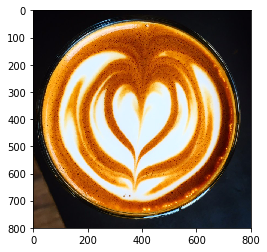

In [3]:
content_image = scipy.misc.imread("images/IMG_2581.jpeg")
imshow(content_image)

In [4]:
## Compute Content Cost - this function measures how different a_C and a_G are
def compute_content_cost(a_C, a_G):
    ##Retrieve Dimensions of a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    ##Reshape a_C and a_G
    a_C_unrolled = tf.transpose(a_C)
    a_G_unrolled = tf.transpose(a_G)
    
    ##Compute Cost with tensorflow
    J_content = (1 /( 4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.pow(a_C_unrolled - a_G_unrolled, 2))
    
    return J_content

In [5]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1,4,4,3], mean=1, stddev=4)
    a_G = tf.random_normal([1,4,4,3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.76559


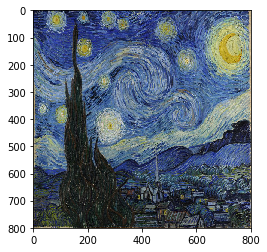

In [6]:
style_image = scipy.misc.imread("images/rsz_1920px-van_gogh_-_starry_night_-_google_art_project.jpg")
imshow(style_image)

In [7]:
## Gram Matrix - GM is used to compare how similar dot products are
## Gram matrix is essentially a cross product matrix multiplied by its transpose

def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    print("GA = " + str(GA.eval()))

GA = [[  6.42230511  -4.42912197  -2.09668207]
 [ -4.42912197  19.46583748  19.56387138]
 [ -2.09668207  19.56387138  20.6864624 ]]


In [9]:
## Compute Style Layer Cost
## This function computes the style cost for a single layer

def compute_layer_style_cost(a_S, a_G):
    ## Retrieve dimensions
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    ## Reshape images to shape H*W, C
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))
    
    ## Get Gram Matrix of a_G and a_S
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = (1. / (4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS-GG), 2))
    
    return J_style_layer

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.19028


In [11]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)
]

In [12]:
## This one just calls style_layer_cost a number of times
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0
    
    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        
        J_style += coeff * J_style_layer
    
    return J_style

In [13]:
## Total Cost to Optimize
## A and B are hyperparams that control relative weighting
## Total cost is a linear combination of content cost and style cost

def total_cost(J_content, J_style, alpha=10, beta=40):
    
    J = alpha * J_content + beta * J_style
    
    return J

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [15]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

content_image = scipy.misc.imread("images/IMG_2581.jpeg")
content_image = reshape_and_normalize_image(content_image)

style_image = scipy.misc.imread("images/rsz_1920px-van_gogh_-_starry_night_-_google_art_project.jpg")
style_image = reshape_and_normalize_image(style_image)

In [16]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

ValueError: Floating point image RGB values must be in the 0..1 range.

In [21]:
## Assign content image to be the input of the model

model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
sess.run(model['input'].assign(content_image))
out = model['conv4_1']
a_S = sess.run(out)
a_G = out
J_content = compute_content_cost(a_S, a_G)

In [22]:
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)
J = total_cost(J_content, J_style, alpha=20, beta=20)

In [23]:
## Define Optimizer
optimizer = tf.train.AdamOptimizer(2.0)

# Define train step
train_step = optimizer.minimize(J)


In [26]:
## this function initializes variables, assigns input image and runs train_step
def model_nn(sess, input_image, num_iterations=200):
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_image))
    
    for i in range (num_iterations):
        sess.run(train_step)
        generated_image = sess.run(model["input"])
        
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration:"+str(i)+" : ")
            print("total cost="+str(Jt))
            print("content cost="+str(Jc))
            print("style_cost="+str(Js))
            
            save_image("output/"+str(i)+".png", generated_image)
        
    save_image("output/generated_image.jpg", generated_image)
    return generated_image


In [27]:
model_nn(sess, generated_image)

Iteration:0 : 
total cost=1.9925e+09
content cost=33224.4
style_cost=9.95919e+07
Iteration:20 : 
total cost=2.41703e+08
content cost=50304.7
style_cost=1.20348e+07
Iteration:40 : 
total cost=7.62604e+07
content cost=54161.6
style_cost=3.75886e+06
Iteration:60 : 
total cost=4.44488e+07
content cost=54889.0
style_cost=2.16755e+06
Iteration:80 : 
total cost=3.23832e+07
content cost=55279.8
style_cost=1.56388e+06
Iteration:100 : 
total cost=2.54719e+07
content cost=55662.8
style_cost=1.21793e+06
Iteration:120 : 
total cost=2.07116e+07
content cost=56025.4
style_cost=979553.0
Iteration:140 : 
total cost=1.71768e+07
content cost=56368.9
style_cost=802471.0
Iteration:160 : 
total cost=1.44601e+07
content cost=56679.4
style_cost=666326.0
Iteration:180 : 
total cost=1.23264e+07
content cost=56958.0
style_cost=559360.0


array([[[[ -7.74063540e+00,   9.27587605e+00,   4.74945602e+01],
         [ -3.47517319e+01,  -8.82667770e+01,   7.34850168e-02],
         [ -7.84885330e+01,  -9.23171768e+01,   1.01391439e+01],
         ..., 
         [ -1.76808109e+01,   1.17393332e+01,   1.61287975e+01],
         [ -1.03660212e+01,  -6.15705757e+01,   3.46548462e+01],
         [  5.91452456e+00,   1.97179890e+01,   2.51547203e+01]],

        [[ -2.46512527e+01,  -7.21233063e+01,   1.03544365e+02],
         [ -8.38069000e+01,  -8.65953217e+01,  -3.90696983e+01],
         [ -1.17309845e+02,  -6.74182510e+01,   3.78515129e+01],
         ..., 
         [ -2.72617092e+01,  -6.03959732e+01,  -9.67402577e-01],
         [ -8.93452835e+01,  -8.36072083e+01,  -3.72860374e+01],
         [  3.26444244e+01,  -5.18859444e+01,   8.97592316e+01]],

        [[ -2.47978973e+01,  -1.10698681e+01,   3.42025032e+01],
         [ -7.85829239e+01,  -6.64620895e+01,   6.92823410e+01],
         [ -1.05559616e+02,  -6.32559128e+01,   2.950126